# Rationale

This notebook is a variation on `01_minimal_environment`, where the active inference agent represents its internal belief with probabilities of the categorical distribution instead of the logits. This modification allows us to greatly simplify belief updates and action selection by avoiding the need to perform any optimisation of the variational distribution. We've observed a 5x speedup in the computation of the agent's `step`.



#### Housekeeping (run once per kernel restart)

In [1]:
# change directory to parent
import os
os.chdir('..')
print(os.getcwd())

/nfs/git/InteractiveInference/src/hello_world


# Imports

In [2]:
import importlib
import itertools
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

import minimal_environment as me
importlib.reload(me)

<module 'minimal_environment' from '/nfs/git/InteractiveInference/src/hello_world/minimal_environment.py'>

# Active Inference

## Belief Update

An active inference agent holds a belief about the state of the environment at time $t$, modelled as a probability distribution $Q(s; \theta_t)$ over states $s \in \mathcal{S}$. There is uncertainty associated with this belief as the state cannot be observed directly and must instead be inferred from stochastic observations.

### Update through Time

At any time $t$ an agent holds a prior belief about $s_t$ before taking in an observation from its environment. This belief could be uniform, for example at the start of an interaction. It could also be informed by propagating the belief $Q(s; \theta_{t-1})$ about state $s_{t-1}$ through its model of the environment transition dynamics, taking into account the action $a_{t-1}$ taken at the previous time step.

$$Q(s; \theta_{t}) = \mathbb{E}_{s\sim Q_{t-1}}[p(s_t|s, a_{t-1})]$$

Note that updating the belief in light of the chosen action usually involves fitting the parameters $\theta_t$. For our minimal agent, we represent $Q(s;\theta)$ as the categorical distribution with $\theta_t = {p_i}$ representing probability of each discrete state. This allows exact inference avoiding the need for optimisation of variational parameters.

In [3]:
def update_belief_a(env, q_last, a):
  return q_last @ env.p_s1_given_s_a[:,a,:]

Let's see the effect of this belief update in action. Say we believed strongly that the environment was in states 1 or 4 with equal probability at time $t$ and we took action 1 (move right). Recall that according to the environment dynamics there is some probability of the state remaining unchanged.

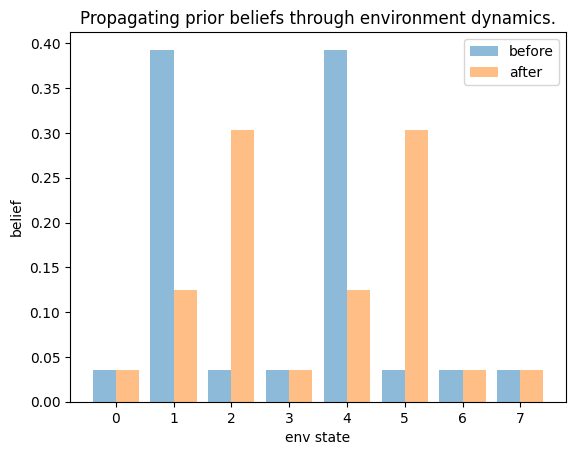

In [4]:
env = me.MinimalEnv(N=8,s_food=0)

# prior belief
q0 = np.ones(env.s_N) * 0.1 + np.eye(env.s_N)[1] + np.eye(env.s_N)[4]
q0 = q0 / q0.sum()

# propagating belief through dynamics, conditioned on action a
q1 = update_belief_a(env, q0, a=1)

plt.bar(np.arange(env.s_N)-0.2, width=0.4, height=q0, alpha=0.5, label='before') # belief before update
plt.bar(np.arange(env.s_N)+0.2, width=0.4, height=q1, alpha=0.5, label='after') # belief before update
plt.xlabel('env state')
plt.ylabel('belief')
plt.title('Propagating prior beliefs through environment dynamics.')
plt.legend()

### Update based on new observation

Now that we have updated our prior taking into account the action taken in the previous time step and the (agent's model of the) environment dynamics, we turn our attention to updating beliefs in light of a new observation.

In active inference, this belief update is cast as minimizing the variational free energy, i.e. minimizing the KL-divergence between $Q(s;\theta')$ and $p(o, s) = Q(s; \theta) p(o|s)$ with respect to $\theta'$.

$$D_{KL}(\quad Q_{\theta'}(s), p(o|s)Q_{\theta}(s) \quad) \quad = \quad \mathbb{E}_{s \sim Q_{\theta'}}[\quad \log Q_{\theta'}(s) - \log p(o|s)Q_{\theta}(s) \quad]$$

As above, we can compute the posterior belief exactly due to our parameterisation of the belief distribution.

In [5]:
def update_belief(env, q_last, o):
  joint = env.p_o_given_s[:,o] * q_last
  return joint / joint.sum()

def update_belief_all(env, q_last):
  joint = env.p_o_given_s.T * q_last
  return joint / joint.sum(axis=1, keepdims=True)

Let's see the effect of this in action. We start with a uniform prior belief. Recall that the food source is in state 0 and that the probability of observing food decreases exponentially with the distance of a state from the food source, with the state space wrapping around.

If we observed no food ($o=0$), then it is most likely that we are in the state furthest away from the food source. If we observed food ($o=1$), then it is most likely that we are at the food source.

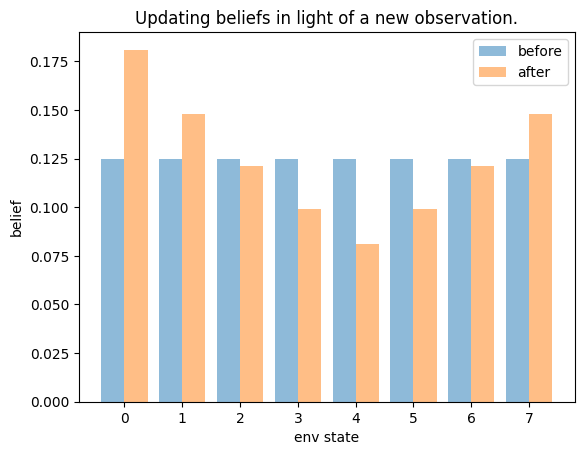

In [6]:
o = 1

env = me.MinimalEnv(N=8,s_food=0)
q0 = np.ones(env.s_N)/env.s_N
q1 = update_belief(env, q0, o=o)

plt.bar(np.arange(env.s_N)-0.2, width=0.4, height=q0, alpha=0.5, label='before') # belief before update
plt.bar(np.arange(env.s_N)+0.2, width=0.4, height=q1, alpha=0.5, label='after') # belief before update
plt.xlabel('env state')
plt.ylabel('belief')
plt.title('Updating beliefs in light of a new observation.')
plt.legend()

### Accumulating observations over time

Note that, based on a single observation, we cannot refine our belief to become most confident in a state that is not the food source itself or furthest away from the food source. This can be improved if we accumulate observations from a single state over time. Because the probability of observing food decreases symmetrically to the left and right of the food source, the agent is likely to hold strong beliefs about all states that share the same rate of observing food, but cannot disambiguate these states without action.

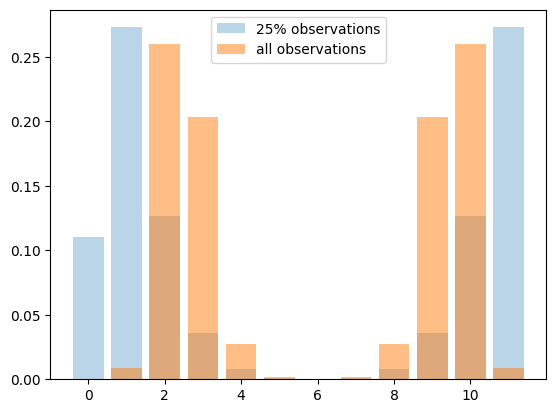

In [7]:
s = 3
n_timesteps = 50

env = me.MinimalEnv(N=12, # number of states
                    s_food=0, # location of the food source
                    s_0=s) # starting location

q = np.ones(env.s_N)/env.s_N # initialize state prior as uniform
o = env.reset() # set state to starting state

# refine belief by sampling N observations but without taking any action
qq = []
for i in range(n_timesteps):
    q = update_belief(env, q_last=q, o=int(o))
    qq.append(q)
    o = env.sample_o()

plt.bar(range(env.s_N), qq[int(len(qq)*0.25)], alpha=0.3, label='25% observations');
plt.bar(range(env.s_N), qq[-1], alpha=0.5, label='all observations');
plt.legend()

## Action Selection

In active inference, sequences of actions (plans, policies) are scored by the negative expected free energy, and selected by exponentiating and normalizing, i.e. sampling from the softmax over plans. Plans $\pi: a_0, a_1, ..., a_{K-1}$ define sequences of actions up to a finite horizon of $K$ timesteps into the future.

The expected free energy can be decomposed in various ways and here we chose one that we find most intuitive, involving a _pragmatic_ term and an _information gain_ term (See Eq 4.9, page 73 in the book). 

The _pragmatic_ term assesses the probability of arriving in states following $\pi$ that the agent desires, or of encountering observations that the agent desires. In this context, $Q_\theta$ is estimated by propagating beliefs through the environment transition dynamics following the sequence of actions defined by $\pi$, and observations are halucinated by sampling from the emission probability distributions.

$\mathbb{E}_{s \sim Q_{\theta}}\left[\log p_c(s)\right] \quad \text{or} \quad \mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[\log p_c(o)\right]$

The _information gain_ term quantifies the belief update due to making observations in future states.

$\mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[ D_{KL}(\, Q_{\theta'}(s|o),  Q_{\theta}(s) \,) \right]$



In [8]:
 
def qs_π( env , q_start, pi ):
  """ propagate q through env following all steps in pi. """
  q_ss = np.empty(shape=pi.shape+ q_start.shape)
  q = q_start
  for i, a in enumerate(pi):
    q = q @ env.p_s1_given_s_a[:,a,:]
    q_ss[i] = q
  return q_ss

def softmax(x):
  e = np.exp(x - x.max())
  return e / e.sum()


def select_action(env, q_star, q_start, 
                  k=4, # planning horizon (number of sequential actions per plan)
                  β=1., # Bolzmann inverse temperature for policy selection
                  use_info_gain=True, 
                  use_pragmatic_value=True,
                  select_max_π=False, # replace sampling with best action selection
                  debug=False, # return plans, p of selecting each, and marginal p of actions
                 ):
  
    # genrate all plans
    πs = np.asarray( 
      [x for x in itertools.product( range(env.a_N), repeat=k )]
    )

    # evaluate negative expected free energy of all plans
    num_πs = πs.shape[0]
    nefes = np.zeros( shape=num_πs )
    log_p_c = np.log( q_star )
    for i, π in tqdm( zip( range(num_πs), πs ) ):
                     
        q_ss = qs_π( env, q_start, π )
        
        # pragmatic value vectorized over timestep t
        if use_pragmatic_value:
          nefes[i] = np.dot(q_ss, log_p_c).sum()

        # info gain vectorized over timestep t
        if use_info_gain:
          p_oo = q_ss @ env.p_o_given_s
          joint = q_ss[...,None] * env.p_o_given_s # shape: T x S x O
          q_oo = joint / joint.sum( axis=1, keepdims=True ) # sum over state dimension
          d_oo = (q_oo * (np.log( q_oo ) - np.log( q_ss )[...,None])).sum( axis=1 )
          nefes[i] += ( d_oo * p_oo ).sum() # sum over o and t
        
    # compute probability of following each plan
    p_πs = softmax( β * nefes )
    
    if select_max_π:
        π = πs[ np.argmax(nefes) ]
    else:    
        π = πs[ np.random.choice( num_πs, p=p_πs ) ]
    
    if debug:
        p_a = np.zeros( env.a_N )
        for a in range( env.a_N ):
          p_a[a] = ( πs[:,0] == a) @ p_πs
            
        return π, p_a, πs, p_πs
    
    return π

Let's explore action selection from plans with horizon $k$ by specifying sharp priors on the starting state and target state $k-1$ steps apart.

If the starting state is to the right of the target (recall the state space wraps around), then policies that take a sequence of left actions ($a=0$)) are scored higher. Note that this holds true irrespective of the food source location. 

If the starting state is to the left of the target (e.g., $s_0=11$), then policies that take a sequence of right actions ($a=1$) are scored higher.

If the starting state and the target state coincide, then policies that take equal numbers of left and right actions are scored highest.



In [9]:
N = 32
k = 15
starting_state = 8
target_state = ( starting_state + k - 3) % N
print(f'Move from {starting_state}/{N} to {target_state}/{N} in at most {k} steps')

env = me.MinimalEnv(N=N, # number of states
                    s_food=0) # location of the food source

# initialize belief
q_start = np.eye(env.s_N)[starting_state] + np.ones(env.s_N) * 0.01
q_start = q_start / q_start.sum()

# initialize preference
q_star = np.eye(env.s_N)[target_state] + 1e-6 * np.ones(env.s_N)
q_star = q_star / q_star.sum()

a, p_a, πs, p_πs = select_action(env, q_star, q_start, 
                                    k=k, # planning horizon
                                    β=1., # Bolzmann inverse temperature
                                    use_pragmatic_value=True,
                                    use_info_gain=True,
                                    debug=True)

# and explore what the agent prefers
#fig, ax = plt.subplots( figsize=(64, 6) )
#plt.bar(x = range( πs.shape[0] ), height=p_πs )
#plt.xlabel('π id')
#plt.ylabel('p(π)')

# estimate marginal probability of selecting a plan with first action 0 or 1
print('marginal probability of next action')
print(p_a)

print('most likely plan')
print(πs[ np.argmax(p_πs) ], f'p(π): {np.max(p_πs):.4f}')

Move from 8/32 to 20/32 in at most 15 steps


32768it [00:02, 11941.97it/s]

marginal probability of next action
[0.48822724 0.51177276]
most likely plan
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] p(π): 0.0109


## Putting it all together

Now we have all components required to define a complete Active Infererence agent. Let's encapsulate it into a class that manages the target state and current belief state over time and provides a minimal interface with reset and step methods.


In [10]:
def np_safelog(x):
  return np.log( np.maximum(x, 1e-16) )

class MinimalAgent:
    """ Minimal agent performing exact inference in fully discrete POMDPs"""
    def __init__(self, 
                 env,
                 target_state, 
                 k=2, # planning horizon
                 β=1, # Bolzmann inverse temperature for policy sampling
                 use_info_gain=True, # score actions by info gain
                 use_pragmatic_value=True, # score actions by pragmatic value
                 select_max_π=False): # sample plan (False), select max negEFE (True).
        self.env = env
        self.target_state = target_state
        self.k = k
        self.β = β
        self.use_info_gain = use_info_gain
        self.use_pragmatic_value = use_pragmatic_value
        self.select_max_π = select_max_π
        print(f'Enumerating {self.env.a_N**k:,} candidate policies of length {k}')
        self.πs = np.stack(np.meshgrid(*[np.arange(self.env.a_N) for _ in range(k)])).T.reshape(-1, k)
        
    def reset(self):
        # initialize state preference
        q_star = np.eye(self.env.s_N)[self.target_state] \
                 + 0.01 * np.ones(self.env.s_N)
        self.q_star = q_star / q_star.sum()
        self.log_p_c = np.log( self.q_star )
        # initialize state prior as uniform
        self.q = np.ones(self.env.s_N) / self.env.s_N
        
    def step(self, o):
        # update belief based on observation
        joint = self.q * self.env.p_o_given_s[:,int(o)]
        self.q = joint / joint.sum()
        π = self._select_π()
        # propagate belief through time assuming we take action a
        self.q = self.q @ self.env.p_s1_given_s_a[:,π[0],:]
        return π[0]
      
    @staticmethod
    def _qs_π(p, q_start, π):
        """ propagate q through env following all steps in pi. """
        num_t = π.shape[0]
        q_ss = np.empty(shape= π.shape + q_start.shape)
        q = q_start
        for i, a in zip( range(num_t), π ):
          q = q @ p[:,a,:]
          q_ss[i] = q
        return q_ss
      
    def _select_π(self, debug=False):
      # rollout
      q_ss = np.stack([self._qs_π(self.env.p_s1_given_s_a, self.q, π) for π in self.πs]) # policies x T x states
      # pragmatic value
      pragmatic = (q_ss @ self.log_p_c).sum(axis=1)
      # state info gain
      p_oo = q_ss @ self.env.p_o_given_s # prior
      joint = q_ss[...,None] * self.env.p_o_given_s
      q_oo = joint / joint.sum( axis=2, keepdims=True ) # conditional
      d_oo = (q_oo * (np_safelog( q_oo ) - np_safelog( q_ss )[...,None])).sum( axis=2 ) # KL
      info_gain = (d_oo * p_oo).sum(axis=(1, 2)) # sum over o and t
      #action selection
      nefe = self.use_pragmatic_value* pragmatic + self.use_info_gain * info_gain
      p_πs = softmax(self.β * nefe)
      if self.select_max_π:
          return self.πs[ np.argmax(nefe) ]
      else:    
          return self.πs[ np.random.choice( num_πs, p=p_πs ) ]


The code below iterates over all steps involved in the interaction between the environment and the active inference agent. In each interaction step, the agent updates its belief about the current state given a new observation and selects an action to minimise expected free energy. It then updates its belief assuming the selected action was taken and starts anew by updating its belief based on the next observation.

In [13]:
import importlib
import minimal_agent as ma
importlib.reload(ma)

s_food = 0
s_0 = 6
target_state = 26
N = 32 # number states
k = 14 # planning horizon; run time increases exponentially with planning horizon
T = 128 # number of simulation steps

env = me.MinimalEnv(N=N, # number of states
                    s_food=s_food, # location of the food source
                    s_0=s_0, 
                    o_decay=0.1) # starting location 

agent = MinimalAgent(env=env, 
                        target_state=target_state, 
                        k=k,
                        use_info_gain=True,
                        use_pragmatic_value=True,
                        select_max_π=True)

o = env.reset() # set state to starting state
agent.reset() # initialize belief state and target state distribution

ss = [env.s_t]
qq = [agent.q]
aa = []
    
for i in tqdm( range(T) ):
    a = agent.step(o)
    #print(f"step {i}, s: {env.s_t}, o: {['FOOD', 'NONE'][int(o)]}, p(a): {p_a}, a: {['UP', 'DOWN'][a]}")
    o = env.step(a)
    ss.append(env.s_t)
    qq.append(agent.q)
    aa.append(a)


Enumerating 16,384 candidate policies of length 14


100%|██████████| 128/128 [02:27<00:00,  1.15s/it]


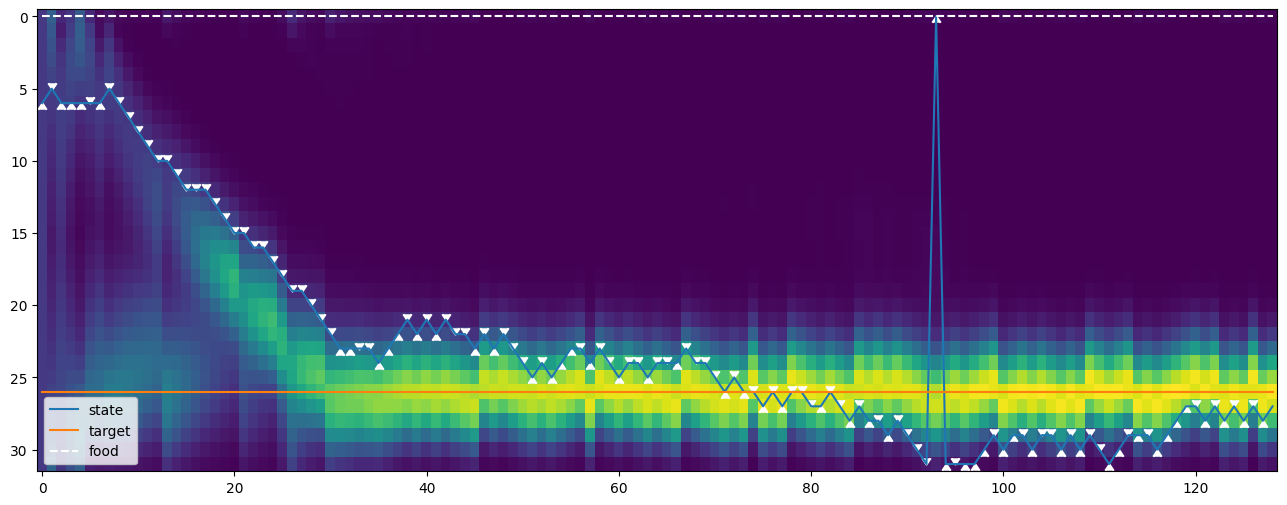

In [ ]:
from matplotlib.markers import CARETUP, CARETDOWN
aa = np.array(aa)
ss = np.array(ss)

fig, ax = plt.subplots(figsize=(16, 6))
plt.imshow(np.array(qq).T, label='belief', aspect='auto')
t = np.arange(len(aa))
i_left = t[aa==0]
i_right = t[aa==1]
plt.scatter(i_left, ss[:-1][i_left], c='white', marker=CARETUP)
plt.scatter(i_right, ss[:-1][i_right], c='white', marker=CARETDOWN)
plt.plot(ss, label='state')
plt.plot([0, len(ss)-1], [target_state]*2, label='target')
plt.plot([0, len(ss)-1], [env.s_food]*2, 'w--', label='food')
plt.legend()
plt.show()

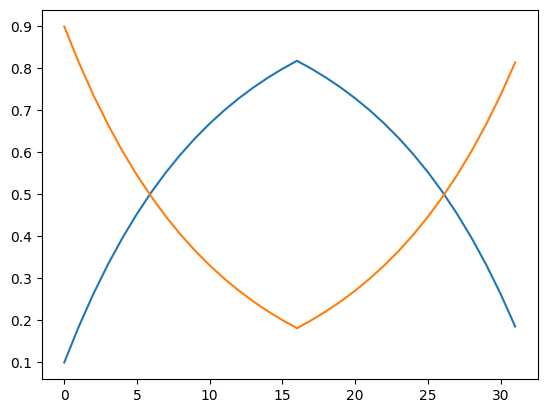

In [15]:
plt.plot(env.p_o_given_s)

## Summary

In this notebook we developed the individual components of an active inference agent that are responsible for updating the agents belief after a new observation arrived and after a new action was taken, and for selecting actions based on the expected free energy, which we separated into an infomation gain term and a pragmatic value term. Each of these components were tested against expected behavior and diagnostic visualisations were introduced that can help adjust learning rates and number of optimization steps and that let us interpret action selection based on the marginal probability of a first action across all evaluated plans.

We put everything together, encapsulated properties, state and methods in the `MinimalAgent` class, and analyzed this agent's sequential interactions with the `MinimalEnvironment`.

There may be potential for further optimizing the code by separating torch compute graph definitions and their application to optimizing each individual interaction step's data.

## Outlook

The agentwe  developed above can interact with environments with
- discrete state spaces
- discrete observation spaces
- discrete action spaces

In subsequent notebooks, we will modify the agent to enable interaction with environments that have

1. continuous action spaces
2. continuous observation spaces
3. continuous state spaces